#### **Thêm các thư viện cần thiết**

In [4]:
import numpy as np
import os

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Model
from keras import layers, models

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
HEIGHT=256
WIDTH=256
BATCH_SIZE=32
IMAGE_SIZE=(HEIGHT, WIDTH)
CHANNEL=3
INPUT_SHAPE= (BATCH_SIZE, WIDTH, HEIGHT, CHANNEL)

#### **Tải dữ liệu huấn luyện**

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "datasets",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
name_classes=dataset.class_names
print("Số lớp: ", name_classes)

Found 2151 files belonging to 3 classes.
Số lớp:  ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


#### **Trực quan hóa hình ảnh**

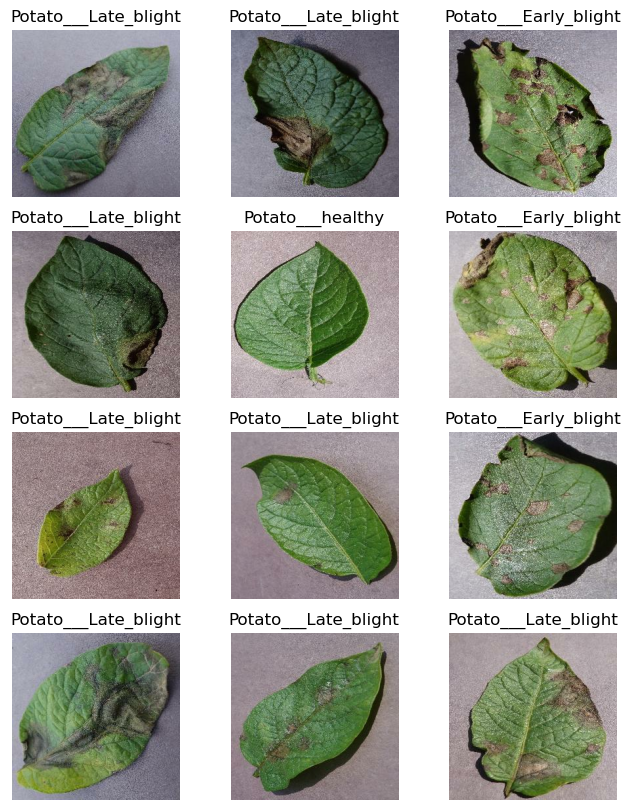

In [4]:
plt.figure(figsize=(8, 10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
      ax= plt.subplot(4, 3, i+1,)
      plt.imshow(image_batch[i].numpy().astype('uint8'))
      plt.axis('off')
      plt.title(name_classes[label_batch[i]])




#### **Chia tập dữ liệu thành 3 tập:**
80% train 10% validate 10% test

In [5]:
def get_datasets_partition_tf(ds, train_split=0.8, validate_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size= len(ds)
  train_size= int(train_split * ds_size)
  validate_size=int(validate_split * ds_size)
  if shuffle:
    ds=ds.shuffle(shuffle_size, seed=12)
  train_ds= ds.take(train_size)
  validate_ds= ds.skip(train_size).take(validate_size)
  test_ds=ds.skip(train_size).skip(validate_size)
  return train_ds, validate_ds, test_ds


train_set, validation_set, test_set= get_datasets_partition_tf(dataset)
print("Dataset batch size", len(dataset))
print("Train batch size= {}, validation batch size= {} test batch size ={}".format(len(train_set), len(validation_set),len(test_set)))

Dataset batch size 68
Train batch size= 54, validation batch size= 6 test batch size =8


#### **Tiền xử lý dữ liệu và tăng cường dữ liệu**

In [23]:
image= plt.imread('image_test/0.jpg')

def show_image(data):
    plt.figure(figsize=(4, 6))
    plt.imshow(data)
    plt.axis('off')


Min and max pixel values: 0.0 1.0


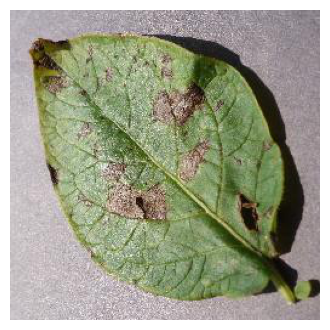

In [16]:
resize_and_rescale= tf.keras.Sequential(
    [
        layers.Resizing(HEIGHT, WIDTH),
        layers.Rescaling(1./255)
    ]
)

img_resize_rescale= resize_and_rescale(image)

show_image(img_resize_rescale)
print("Min and max pixel values:", img_resize_rescale.numpy().min(), img_resize_rescale.numpy().max())




In [8]:
data_augmentation= tf.keras.Sequential(
    [
        layers.RandomRotation(0.2),
        layers.RandomFlip( "horizontal_and_vertical")

    ]
)




#### **Xây dựng mô hình**

In [9]:
model= tf.keras.Sequential(
    [
        resize_and_rescale,
        data_augmentation,
        Conv2D(32, (3, 3),activation='relu', input_shape=INPUT_SHAPE ),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3),activation='relu', ),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3),activation='relu', ),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3),activation='relu', ),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ]
)
model.build(input_shape=INPUT_SHAPE)

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                  

In [11]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history=model.fit(
    train_set,
    batch_size=BATCH_SIZE,
    epochs=10,
    verbose=1,
    validation_data=test_set,
    )

Epoch 1/10
54/54 [==============================] - 26s 257ms/step - loss: 0.8174 - accuracy: 0.5925 - val_loss: 0.7542 - val_accuracy: 0.7148
Epoch 2/10
54/54 [==============================] - 12s 190ms/step - loss: 0.3801 - accuracy: 0.8456 - val_loss: 0.3904 - val_accuracy: 0.8711
Epoch 3/10
54/54 [==============================] - 11s 183ms/step - loss: 0.2723 - accuracy: 0.8987 - val_loss: 0.3299 - val_accuracy: 0.8203
Epoch 4/10
54/54 [==============================] - 11s 176ms/step - loss: 0.2181 - accuracy: 0.9107 - val_loss: 0.1603 - val_accuracy: 0.9375
Epoch 5/10
54/54 [==============================] - 10s 162ms/step - loss: 0.1999 - accuracy: 0.9284 - val_loss: 0.2614 - val_accuracy: 0.8828
Epoch 6/10
54/54 [==============================] - 9s 158ms/step - loss: 0.2437 - accuracy: 0.9025 - val_loss: 0.2402 - val_accuracy: 0.9180
Epoch 7/10
54/54 [==============================] - 10s 163ms/step - loss: 0.1554 - accuracy: 0.9395 - val_loss: 0.1386 - val_accuracy: 0.9375


#### **Lưu mô hình**

In [12]:
model_names=os.listdir("./models")
if  len(model_names)==0:
  model_names=[0]
version= np.max([int(name) for name in model_names])+1
model.save(f"./models/{version}")

INFO:tensorflow:Assets written to: ./models/3\assets


INFO:tensorflow:Assets written to: ./models/3\assets


#### **Trực quan bản đồ đặc trưng**

In [24]:
cnn_model= models.load_model("./models/2")

for i in range(len(cnn_model.layers)):
    layer = cnn_model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i , layer.name , layer.output.shape)

2 conv2d (None, 254, 254, 32)
4 conv2d_1 (None, 125, 125, 32)
6 conv2d_2 (None, 60, 60, 32)
8 conv2d_3 (None, 28, 28, 32)


#### **Đánh giá**

In [32]:
score=model.evaluate(test_set)

8/8 [==============================] - 2s 29ms/step - loss: 0.0954 - accuracy: 0.9570


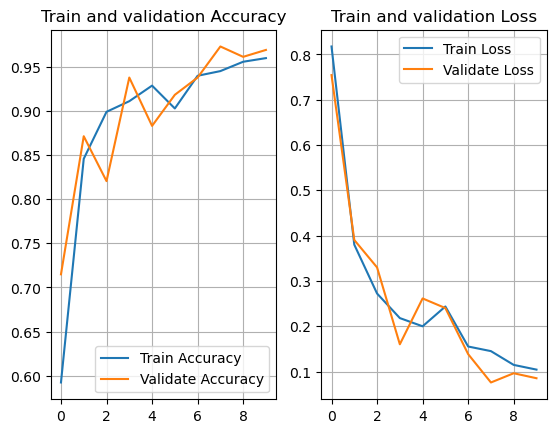

In [33]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Train Accuracy')
plt.plot(range(10), val_acc, label='Validate Accuracy')
plt.title("Train and validation Accuracy")
plt.legend(loc='lower right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Train Loss')
plt.plot(range(10), val_loss, label='Validate Loss')
plt.title("Train and validation Loss")
plt.legend(loc='upper right')
plt.grid()


1/1 [==============================] - 0s 21ms/step


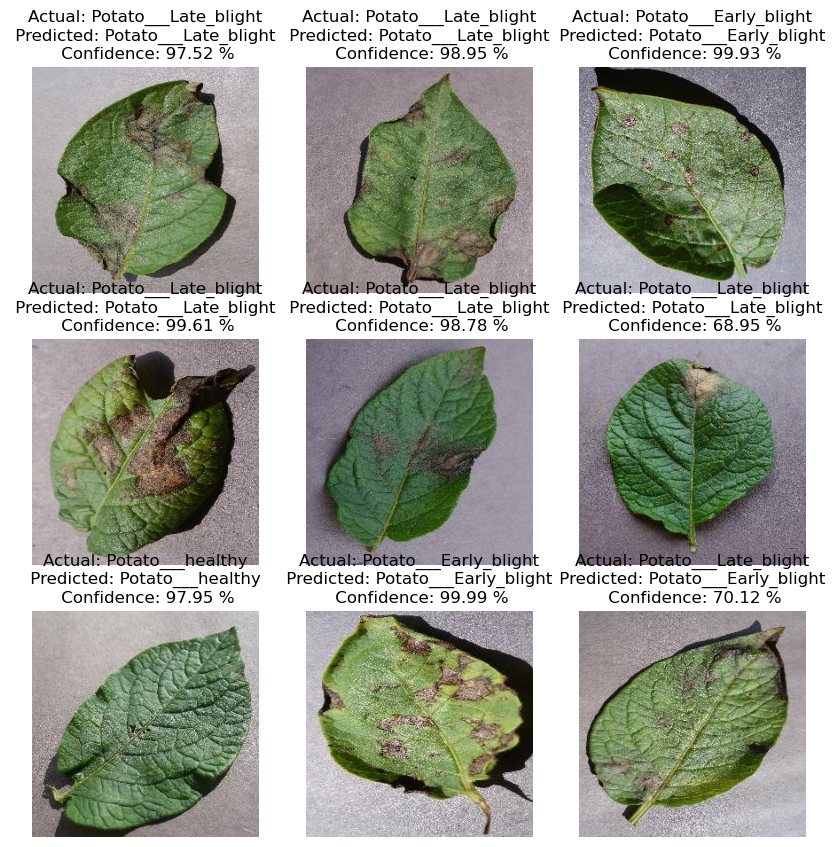

In [35]:
def predict(model, img):
  img_arr=tf.keras.preprocessing.image.img_to_array(img)
  img_arr= tf.expand_dims(img_arr, 0)

  predictions= model.predict(img_arr)
  predicted_class= name_classes[np.argmax(predictions[0])]
  confidence= round(100 * np.max(predictions[0]), 2)
  return predicted_class, confidence

plt.figure(figsize=(10, 10))
for images, labels in test_set.take(1):
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence= predict(model,images[i].numpy())
    acctual_class= name_classes[labels[i]]
    plt.title(f"Actual: {acctual_class}\n Predicted: {predicted_class} \n Confidence: {confidence} %")
    plt.axis('off')